# Machine Learning Prototype

The idea is that we're going to create several different models and compare performance. The statsmodel api returns a lot of useful metrics to evaulate our model performance, so we'll use that to begin with. We'll build up a simple intuitive, baseline model and progressively add more features to the model, as well as eventually testing with a new PCA matrix.

In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from ml_metrics import rmse
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
import statsmodels.formula.api as smf
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.base import clone
from sklearn import preprocessing
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from patsy import dmatrices

read in engineered data from previous notebook, 02 Exploratory Data Analysis. 

In [2]:
engineered_df = pd.read_csv("data/engineered_df.csv")
engineered_df = engineered_df.sample(frac=.005, replace = False,random_state=42)
engineered_df.reset_index(inplace = True)
engineered_df.drop(columns = "index", inplace = True)
print(engineered_df.shape)
engineered_df.head()

(15514, 41)


,stars,log_useful,readability grades Kincaid,readability grades ARI,readability grades Coleman-Liau,readability grades FleschReadingEase,readability grades GunningFogIndex,readability grades LIX,readability grades SMOGIndex,readability grades RIX,...,sentence beginnings pronoun,sentence beginnings interrogative,sentence beginnings article,sentence beginnings subordination,sentence beginnings conjunction,sentence beginnings preposition,neg,neu,pos,compound
0,5,0.000000,12.402759,14.508621,9.942405,57.793103,17.117241,56.586207,13.954451,8.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.526,0.474,0.9260
1,5,0.000000,1.222756,0.835769,2.874822,103.661827,4.925641,14.878205,5.738613,0.500000,...,1.0,0.0,1.0,1.0,0.0,0.0,0.000,0.507,0.493,0.8658
2,3,0.693147,4.762500,6.541271,7.905170,87.189174,9.967797,30.004237,9.708204,2.250000,...,1.0,0.0,0.0,1.0,1.0,1.0,0.121,0.593,0.286,0.7511
3,3,0.000000,6.933108,7.805676,7.549522,78.306149,10.643243,34.716216,9.708204,3.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.305,0.614,0.081,-0.7124
4,5,0.693147,7.202678,8.501350,6.538927,82.445406,11.917163,34.357224,10.198485,2.727273,...,4.0,0.0,1.0,1.0,0.0,1.0,0.136,0.674,0.190,0.8153


In [3]:
X,y = engineered_df.drop(columns = ["log_useful"]), engineered_df.log_useful
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)
print(X_train.shape, X_test.shape)

(10859, 40) (4655, 40)


### Initial Intuitive Baseline Model
Here we'll create and evaluate a baseline model with intuitive features. We'll use stars and number of characters in a review to predict the log usefulness of it. Remember we found from the previous notebook that lower rated reviews tend to be more useful, as well as longer reviews being more useful. We made sense of this by noticing that the more stars the user gave the restaurant business, the shorter their review was because when people are pleased they're much more likely to leave a generic positive comment and not necessilarly comment on exactly what it was that they liked. On the flip side, lower rated reviews tend to be longer because when someone doesn't have a positive experience, if they're going to leave a review they're almost certainly going to say exactly what it was that made their experience negative so that those reading their review can understand exactly where their sentiment is coming from.

#### Standardize the Data for Linear Regression

Incase you're curious as to why we do this, here is a succint explanation
https://stats.stackexchange.com/questions/29781/when-conducting-multiple-regression-when-should-you-center-your-predictor-varia

"In regression, it is often recommended to center the variables so that the predictors have mean 0. This makes it so the intercept term is interpreted as the expected value of 𝑌𝑖 when the predictor values are set to their means. Otherwise, the intercept is interpreted as the expected value of 𝑌𝑖 when the predictors are set to 0, which may not be a realistic or interpretable situation (e.g. what if the predictors were height and weight?). Another practical reason for scaling in regression is when one variable has a very large scale, e.g. if you were using population size of a country as a predictor. In that case, the regression coefficients may be on a very small order of magnitude (e.g. 10−6) which can be a little annoying when you're reading computer output, so you may convert the variable to, for example, population size in millions. The convention that you standardize predictions primarily exists so that the units of the regression coefficients are the same."

In this case, since we're going to use character count, and there is a high degree of variability here, the second reason in the above explanation is applicable. In general this just makes our results a lot more interprettable

In [4]:
X_standarized = preprocessing.scale(X_train)
X_standarized = pd.DataFrame(X_standarized, columns = X.columns)
X_standarized.head()
standarized_df = pd.concat([X_standarized, y], axis = 1)

In [5]:
def sm_Col_Generator(columns):
    cols = None
    for i, col in enumerate(columns):
        if i == 0:
            cols = col
        elif " " in col:
            cols = cols + " + " + 'Q("' + str(col) + '")'
        else:
            cols = cols + " + " + col
    return cols

In [6]:
features = sm_Col_Generator(["stars", "sentence info characters"])
smresults = smf.ols(formula = 'log_useful ~ ' + features, data=standarized_df).fit()
smresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_useful   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4331
Date:                Mon, 27 Apr 2020   Prob (F-statistic):              0.648
Time:                        20:59:46   Log-Likelihood:                -10235.
No. Observations:               10859   AIC:                         2.048e+04
Df Residuals:                   10856   BIC:                         2.050e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.4159      0.006     69.772      0.000       0.404       0.428
stars                            -0.0005      0.006     -0.084      0.933      -0.012       0.011
Q("sentence info characters")     0.0054      0.006      0.896      0.370      -0.006       0.017
==============================================================================
Omnibus:                     3550.128   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10777.385
Skew:                           1.710   Prob(JB):                         0.00
Kurtosis:                       6.482   Cond. No.                         1.20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Observations
R-squared coefficient is not bad for just one feature. Intuitively, we can think of the R-squared here as equal to variation in log useful votes explained by the number of characters in a review, divided by the variation in log useful votes without taking the number of characters into account. Thus, if we had a R-squared value of one, that would signify that our feature for the number of characters in a review perfectly explains and accounts for all of the variance in our target variable, log useful votes. Thus we can interpret our score of .143 as 14.3% of the variance in log useful votes being explained by the number of characters.

Our F-statistic is relatively high. Similar to our R-squared coefficient but with a slightly modified denominator,  we can think of the F-statistic here as equal to variation in log useful votes explained by the number of characters in a review, divided by the variation in log useful votes not explained by the number of characters in a review. Since our value is very high, this means the numerator is much larger than the demoninator, i.e. the variation in log useful votes explained by the number of characters in a review is much larger than the variation in log useful votes not explained by the number of characters in a review, so basically our feature has a lot more significance than non-significance. Note most importantly that Prob (F-statistic) is 0, which is what allows us to give credence to the F-statistic in the first place. You can think of this as meaning if we set the coefficient for the feature characters number of characters to 0, meaning our model doesn't use this feature at all when predicting the log useful votes and only uses the bias (intercept), then our model would be just as good as it was when we did use this feature for our predictions. So, since this 0 that means we are confident that our model would be a lot worse without this feature. 

Two things to note here that we discovered in our previous notebook, Exploratory Data Analysis, which are backed up here by our linear model. First, the coefficient for number of characters is positive, which is indictive of a positive correlation between this and the target variable log useful votes for a review. Secondly, A skew of 1.357 means that our target variable log useful votes is right skewed.


In [7]:
features = sm_Col_Generator(X.columns)
smresults = smf.ols(formula = 'log_useful ~ ' + features, data=standarized_df).fit()
smresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_useful   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.6767
Date:                Mon, 27 Apr 2020   Prob (F-statistic):              0.933
Time:                        20:59:47   Log-Likelihood:                -10223.
No. Observations:               10859   AIC:                         2.052e+04
Df Residuals:                   10821   BIC:                         2.080e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                      0.4159      0.006     69.737      0.000       0.404       0.428
stars                                          0.0083      0.008      0.986      0.324      -0.008       0.025
Q("readability grades Kincaid")                0.0145      0.012      1.254      0.210      -0.008       0.037
Q("readability grades ARI")                    0.0132      0.017      0.781      0.435      -0.020       0.046
Q("readability grades Coleman-Liau")           0.0027      0.021      0.129      0.897      -0.039       0.044
Q("readability grades FleschReadingEase")     -0.0101      0.010     -1.027      0.304      -0.029       0.009
Q("readability grades GunningFogIndex")       -0.0318      0.048     -0.669      0.503      -0.125       0.061
Q("readability grades LIX")                   -0.0004      0.035     -0.011      0.991      -0.068       0.067
Q("readability grades SMOGIndex")              0.0050      0.022      0.228      0.819      -0.038       0.048
Q("readability grades RIX")                   -0.0271      0.023     -1.163      0.245      -0.073       0.019
Q("readability grades DaleChallIndex")        -0.0010      0.010     -0.104      0.917      -0.020       0.018
Q("sentence info characters_per_word")        -0.0055      0.025     -0.223      0.824      -0.054       0.043
Q("sentence info syll_per_word")           -3.646e-05      0.012     -0.003      0.998      -0.023       0.023
Q("sentence info words_per_sentence")          0.0153      0.014      1.120      0.263      -0.011       0.042
Q("sentence info sentences_per_paragraph")     0.0093      0.013      0.702      0.483      -0.017       0.035
Q("sentence info type_token_ratio")           -0.0050      0.013     -0.388      0.698      -0.030       0.020
Q("sentence info characters")                  0.0358      0.262      0.137      0.891      -0.477       0.549
Q("sentence info syllables")                  -0.1061      0.183     -0.581      0.561      -0.464       0.252
Q("sentence info words")                      -0.0759      0.177     -0.429      0.668      -0.423       0.271
Q("sentence info wordtypes")                  -0.0085      0.045     -0.191      0.849      -0.096       0.079
Q("sentence info sentences")                  -0.0239      0.026     -0.936      0.349      -0.074       0.026
Q("sentence info paragraphs")                  0.0099      0.015      0.655      0.512      -0.020       0.040
Q("sentence info long_words")                  0.0476      0.052      0.916      0.360      -0.054       0.150
Q("sentence info complex_words")               0.0012      0.033      0.038      0.969      -0.063       0.065
Q("sentence info complex_words_dc")            0.0375      0.038      0.993      0.321

In [8]:
features = sm_Col_Generator(X.columns)
y_sm, X_sm = dmatrices('log_useful ~ ' + features, standarized_df, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_sm.values, i) for i in range(X_sm.shape[1])]
vif["feature"] = ["intercept"] +  X.columns.tolist()

/Users/jzmichal/opt/anaconda3/envs/yelpEnv/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [9]:
vif

,VIF Factor,feature
0,1.000000e+00,intercept
1,2.013438e+00,stars
2,inf,readability grades Kincaid
3,inf,readability grades ARI
4,1.268906e+01,readability grades Coleman-Liau
5,inf,readability grades FleschReadingEase
6,6.359925e+01,readability grades GunningFogIndex
7,3.352280e+01,readability grades LIX
8,1.354467e+01,readability grades SMOGIndex
9,1.529678e+01,readability grades RIX


In [10]:
X_vif = X_standarized.copy()
for index, row in vif.iterrows():
    if row['VIF Factor'] > 100:
        X_vif.drop(columns = row["feature"], inplace = True)
new_df = pd.concat([X_vif, y], axis = 1)
new_df.head()

,stars,readability grades Coleman-Liau,readability grades GunningFogIndex,readability grades LIX,readability grades SMOGIndex,readability grades RIX,readability grades DaleChallIndex,sentence info sentences_per_paragraph,sentence info type_token_ratio,sentence info wordtypes,...,word usage preposition,word usage nominalization,sentence beginnings pronoun,sentence beginnings interrogative,sentence beginnings article,sentence beginnings subordination,sentence beginnings conjunction,sentence beginnings preposition,compound,log_useful
0,0.180924,-0.772497,-0.429888,-1.073237,-0.420844,-0.940002,-2.044355,-0.577721,1.872434,-1.074409,...,-0.834539,0.294966,-0.608529,-0.29486,-0.753115,-0.405352,-0.31291,-0.423415,0.566271,0.000000
1,0.180924,4.048681,1.727615,2.262690,2.706561,3.382541,0.619251,-1.117138,1.872434,-0.974897,...,-0.834539,-0.593779,-0.954226,-0.29486,-0.753115,-0.405352,-0.31291,-0.423415,0.351418,0.000000
2,0.893274,-0.653806,-0.380126,-0.130696,-0.214913,-0.302996,0.317340,-0.038303,1.039590,-0.676359,...,-0.470743,-0.593779,-0.608529,-0.29486,-0.753115,-0.405352,-0.31291,-0.423415,0.510699,0.693147
3,0.893274,1.543245,-0.484106,0.804444,-0.420844,-0.029993,0.539875,-0.577721,0.973840,-1.074409,...,-0.925489,-0.593779,-0.954226,-0.29486,-0.052997,-0.405352,-0.31291,-0.423415,0.225207,0.000000
4,0.893274,-0.488456,-0.976575,-1.601743,-2.578435,-1.395007,-2.213234,-0.577721,-0.322704,-0.895287,...,-0.834539,-0.593779,-0.954226,-0.29486,-0.753115,-0.405352,-0.31291,-0.423415,0.594448,0.693147


In [11]:
features = sm_Col_Generator(X_vif.columns)
y_sm, X_sm = dmatrices('log_useful ~ ' + features, new_df, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_sm.values, i) for i in range(X_sm.shape[1])]
vif["feature"] = ["intercept"] +  X_vif.columns.tolist()

In [12]:
vif

,VIF Factor,feature
0,1.000000,intercept
1,1.864545,stars
2,2.903765,readability grades Coleman-Liau
3,21.869065,readability grades GunningFogIndex
4,24.893805,readability grades LIX
5,7.151892,readability grades SMOGIndex
6,12.129510,readability grades RIX
7,2.461686,readability grades DaleChallIndex
8,4.800724,sentence info sentences_per_paragraph
9,4.061182,sentence info type_token_ratio


In [13]:
smresults = smf.ols(formula = 'log_useful ~ ' + features, data=new_df).fit()
smresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_useful   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.6647
Date:                Mon, 27 Apr 2020   Prob (F-statistic):              0.909
Time:                        20:59:51   Log-Likelihood:                -10226.
No. Observations:               10859   AIC:                         2.051e+04
Df Residuals:                   10830   BIC:                         2.072e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                      0.4159      0.006     69.745      0.000       0.404       0.428
stars                                          0.0052      0.008      0.636      0.525      -0.011       0.021
Q("readability grades Coleman-Liau")           0.0018      0.010      0.174      0.862      -0.018       0.022
Q("readability grades GunningFogIndex")        0.0071      0.028      0.256      0.798      -0.048       0.062
Q("readability grades LIX")                    0.0022      0.030      0.074      0.941      -0.056       0.061
Q("readability grades SMOGIndex")             -0.0040      0.016     -0.248      0.804      -0.035       0.027
Q("readability grades RIX")                   -0.0152      0.021     -0.731      0.465      -0.056       0.026
Q("readability grades DaleChallIndex")         0.0039      0.009      0.418      0.676      -0.014       0.022
Q("sentence info sentences_per_paragraph")     0.0105      0.013      0.801      0.423      -0.015       0.036
Q("sentence info type_token_ratio")           -0.0061      0.012     -0.504      0.615      -0.030       0.018
Q("sentence info wordtypes")                  -0.0179      0.035     -0.511      0.609      -0.087       0.051
Q("sentence info sentences")                  -0.0368      0.023     -1.572      0.116      -0.083       0.009
Q("sentence info paragraphs")                  0.0101      0.015      0.673      0.501      -0.019       0.039
Q("sentence info long_words")                  0.0304      0.039      0.770      0.442      -0.047       0.108
Q("sentence info complex_words")              -0.0134      0.029     -0.465      0.642      -0.070       0.043
Q("sentence info complex_words_dc")            0.0051      0.033      0.156      0.876      -0.059       0.069
Q("word usage tobeverb")                      -0.0066      0.013     -0.500      0.617      -0.032       0.019
Q("word usage auxverb")                        0.0067      0.008      0.816      0.414      -0.009       0.023
Q("word usage conjunction")                   -0.0057      0.013     -0.439      0.661      -0.031       0.020
Q("word usage pronoun")                       -0.0204      0.019     -1.101      0.271      -0.057       0.016
Q("word usage preposition")                    0.0242      0.019      1.252      0.211      -0.014       0.062
Q("word usage nominalization")                -0.0062      0.008     -0.804      0.421      -0.021       0.009
Q("sentence beginnings pronoun")               0.0315      0.013      2.483      0.013       0.007       0.056
Q("sentence beginnings interrogative")        -0.0068      0.007     -1.045      0.296      -0.020       0.006
Q("sentence beginnings article")               0.0105      0.008      1.292      0.196

### Observations

Similar R-squared. F-statistic, P(F-statistic), and  coefficient for number of characters remain unchanged. Coefficient for number of stars is negative, meaning there our model has detected a negative correlation between log useful votes and number of stars for a review. This is another trend that we picked up on in the previous notebook that is now backed by the model.

There's one other subtle difference in our summary with this model compared to the last. Notice how much higher the conditional number is here, which is essentially a measure of multicollinearity. Multicollinearity is usually viewed in a negative light because ideally you'd like indepence between your features, however it's helpful for this case because it helps with intrepretability. In this sense, it can be intrepretted as there being a high correlation between number of stars for a review and the number of characters in a review. Again, this is incredibly reassuring to see as this was another trend that we picked up on in our Exploratory Data Analysis, which showed that on average, the less stars a review has the more characters it has, which we coupled with the fact that the more characters a review has the more useful it is.

## Deciding The Best Feature Matrix

In the previous notebook, we designed a feature matrix with over 35 NLP features and performed PCA on it. PCA showed us that the first two principal components accounted for just over 70% of the variance in the data. Additionally, we saw that the first principal component's coefficients were highest for our sentiment features, namely stars. The second principal component's coefficients were highest in relation to our category of "sentence info" NLP features, which includes number of characters. This goes hand in hand with why we chose our previous two baseline features to be these. 

Now, we can try and determine what additional features we can include to help the performance of our linear model. There's several metrics we can use to evaluate the performance of our model. We'll look at R-squared, Adjusted R-squared, AIC & BIC, and finally RMSE. Because I haven't gone into the meaning behind some of these terms before, so I'll give a quick overview of what they mean in the context of our model. 

AIC & BIC - These tools of information criterion are widely used in model selection. Roughly, these can be seen as measurements of the tradeoff between goodness of fit and number of variables for a statistical model. Without getting too mathy, we can give the formula for each and a brief description of what's going on

$BIC = \log(n)*k - 2\log(L)$

$AIC = 2*k - 2\log(L)$

where k is the number of features/columns, and n is the number of samples/rows we're using. L is essentially our measure of goodness of fit, so we want this to be high. Our first term in the BIC formula scales with the number of data points and features, while AIC scales with the just the number of features. Since L is a measure of the goodness of fit of our model, obviously we want the second term in both equations to be as higher as possible, which means that we'd like both AIC and BIC to be as low as possible. 

Adjusted R-squared: Similar to r-squared, this takes into account the number of features used to predict by the model. The adjusted r-squared increase only if the new term improves the model more than what would be expected by chance. In contrast, this value decreases when a feature improves the model by less than expected chance, meaning that if we just added a new feature and the adjusted r-squared went down, then this feature doesn't improve the model by a sufficient amount.


PCA performs best when all of the variables have the same potential weight. In order to do that, we'll use MinMaxScaler and change all feature variables to be in the range [0, 1], but also keeps the same proportion between each value.

In [14]:
pca_cols = []
for i in range(20):
    pca_cols.append("PCA_{}".format(i))
X_tr_sub = X_train.copy()
for col in X_train.columns:
    if col not in vif.feature.tolist():
        X_tr_sub.drop(columns=col, inplace = True)
X_tr_sub.head()

,stars,readability grades Coleman-Liau,readability grades GunningFogIndex,readability grades LIX,readability grades SMOGIndex,readability grades RIX,readability grades DaleChallIndex,sentence info sentences_per_paragraph,sentence info type_token_ratio,sentence info wordtypes,...,word usage pronoun,word usage preposition,word usage nominalization,sentence beginnings pronoun,sentence beginnings interrogative,sentence beginnings article,sentence beginnings subordination,sentence beginnings conjunction,sentence beginnings preposition,compound
13131,4,4.572557,6.972549,17.431373,7.472136,0.666667,5.775214,3.0,1.000000,17.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.9571
3575,4,14.926234,16.072727,53.818182,13.954451,7.000000,9.034064,1.0,1.000000,22.0,...,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8473
8972,5,4.827450,7.182439,27.712195,7.898979,1.600000,8.664683,5.0,0.902439,37.0,...,3.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.9287
29,5,9.545707,6.743860,37.912281,7.472136,2.000000,8.936949,3.0,0.894737,17.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.7828
5090,5,5.182547,4.666667,11.666667,3.000000,0.000000,5.568595,3.0,0.742857,26.0,...,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.9715


In [15]:
r2_list, r2_adj_list, aic_list, bic_list, rmse_list_train, rmse_list_test = [0]*20,[0]*20,[0]*20,[0]*20,[0]*20,[0]*20
kf = KFold(n_splits=6, random_state = 13)
#6-Fold Cross-Validation with the training set
for train_index, val_index in kf.split(X_tr_sub, y_train):
    
    X_tr, X_val = X_tr_sub.iloc[train_index], X_tr_sub.iloc[val_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    X_tr = preprocessing.scale(X_tr)
    X_val = preprocessing.scale(X_val)
    rmse_train_total = rmse_test_total = 0
    for i in range(20):
        
        num_cols = i+1
        
        #calculate PCA transformation on training folds
        pca = PCA(n_components=num_cols)
        
        #apply PCA transform to training fold data
        X_tr_pca = pca.fit_transform(X_tr)
        X_tr_pca = pd.DataFrame(X_tr_pca, columns = pca_cols[:num_cols])
        #train model on training fold data
        sk_OLS = LinearRegression()
        sk_OLS.fit(X_tr_pca, y_tr)
        
        #apply PCA transformation to validation fold data
        X_val_pca = pca.transform(X_val)        
        X_val_pca = pd.DataFrame(X_val_pca, columns = pca_cols[:num_cols])
        
        #apply model to training and validation data and calculate loss
        y_hat_tr = sk_OLS.predict(X_tr_pca)
        y_hat_val = sk_OLS.predict(X_val_pca)

        X_tr_pca['log_useful'] = y_train
        features = sm_Col_Generator(pca_cols[:num_cols])
        formula = 'log_useful ~ ' + features
        sm_OLS = smf.ols(formula, data=X_tr_pca).fit()
        aic_list[i]+= sm_OLS.aic
        bic_list[i]+= sm_OLS.bic
        r2_list[i]+=sm_OLS.rsquared
        r2_adj_list[i]+= sm_OLS.rsquared_adj
        rmse_list_train[i]+= rmse(actual = y_tr, predicted = y_hat_tr)
        rmse_list_test[i]+= rmse(actual = y_val, predicted = y_hat_val)

/Users/jzmichal/opt/anaconda3/envs/yelpEnv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


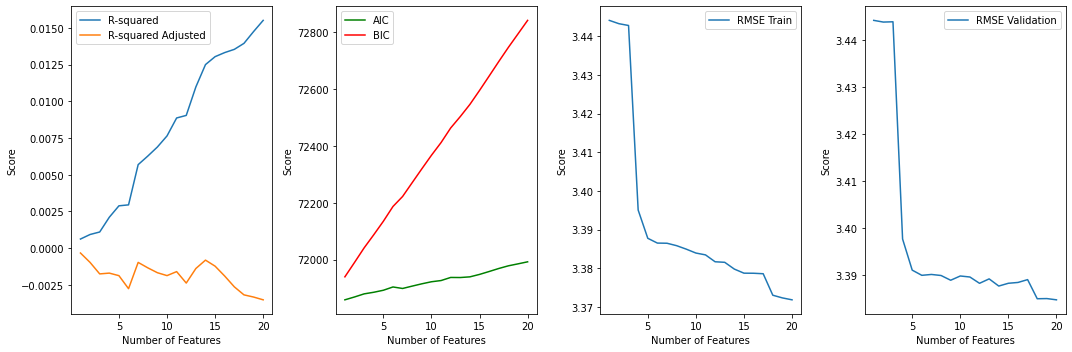

In [16]:
f, ax = plt.subplots(1,4, figsize = (15,5))
num_features = np.arange(1,21)
plt.subplot(141)
plt.plot(num_features, r2_list, label = "R-squared")
plt.plot(num_features, r2_adj_list, label = "R-squared Adjusted")
plt.legend(loc='best')
plt.xlabel('Number of Features')
plt.ylabel("Score")

plt.subplot(142)
plt.plot(num_features, aic_list, label = "AIC", color = "green")
plt.plot(num_features, bic_list, label = "BIC", color = "red")
plt.legend(loc='best')
plt.xlabel('Number of Features')
plt.ylabel("Score")

plt.subplot(143)
plt.plot(num_features, rmse_list_train, label = "RMSE Train")
plt.xlabel('Number of Features')
plt.ylabel("Score")
plt.legend(loc='best')

plt.subplot(144)
plt.plot(num_features, rmse_list_test, label = "RMSE Validation")
plt.xlabel('Number of Features')
plt.ylabel("Score")
plt.legend(loc='best')

plt.tight_layout()
plt.show()

3 Matrices:
1) Original Feature Matrix
2) Feature Matrix with VIF selected features
3) PCA Matrix from VIF matrix


In [26]:
#1 - X_train
#2 - X_vif
#3 - X_pca
pca = PCA(n_components=num_cols)
X_pca = pca.fit_transform(X_train)
X_pca = pd.DataFrame(X_pca, columns = pca_cols)
n_estimators = [10,50,100, 200]
max_features = ['auto', 'sqrt']
max_depth = [5,10,15, None]
min_samples_split = [10]
min_samples_leaf = [4]
bootstrap = [True, False]
# Create the random grid
param_grid = {'n_estimators': n_estimators, 'min_samples_leaf': min_samples_leaf, 
              'min_samples_split': min_samples_split, 'bootstrap': bootstrap, 'max_features': max_features, 
              'max_depth': max_depth}

In [22]:
matrices = [X_train, X_vif, X_pca]
model_list = []
for m in matrices:
    rf = GridSearchCV(RandomForestRegressor(random_state=13), param_grid)
    rf.fit(m, y_train)
    model_list.append(rf.best_estimator_)       

### Random Forest Regression Model

Now we'll look at using more advanced models in order to gain insight into our data. We'll do some hyperparameter tuning in order to find the best parameters for our model, and give a brief overview of what these hyperparameters mean.

n estimators-  number of trees in random forest
max depth - Maximum number of levels in tree
min samples split - Minimum number of samples required to split a node
min samples leaf - Minimum number of samples required at each leaf node
bootstrap - If true, we sample with replacement

### Hyperparameter tuning
Since it takes a substantial amount of time to train and tune the hyperparameters, we'll subsample our data. Then once we find the best hyperparameters, we can train our model on all of the data and compare its performance on the test set with our simpler linear model. 

## Final Model & Data Matrix Comparisons

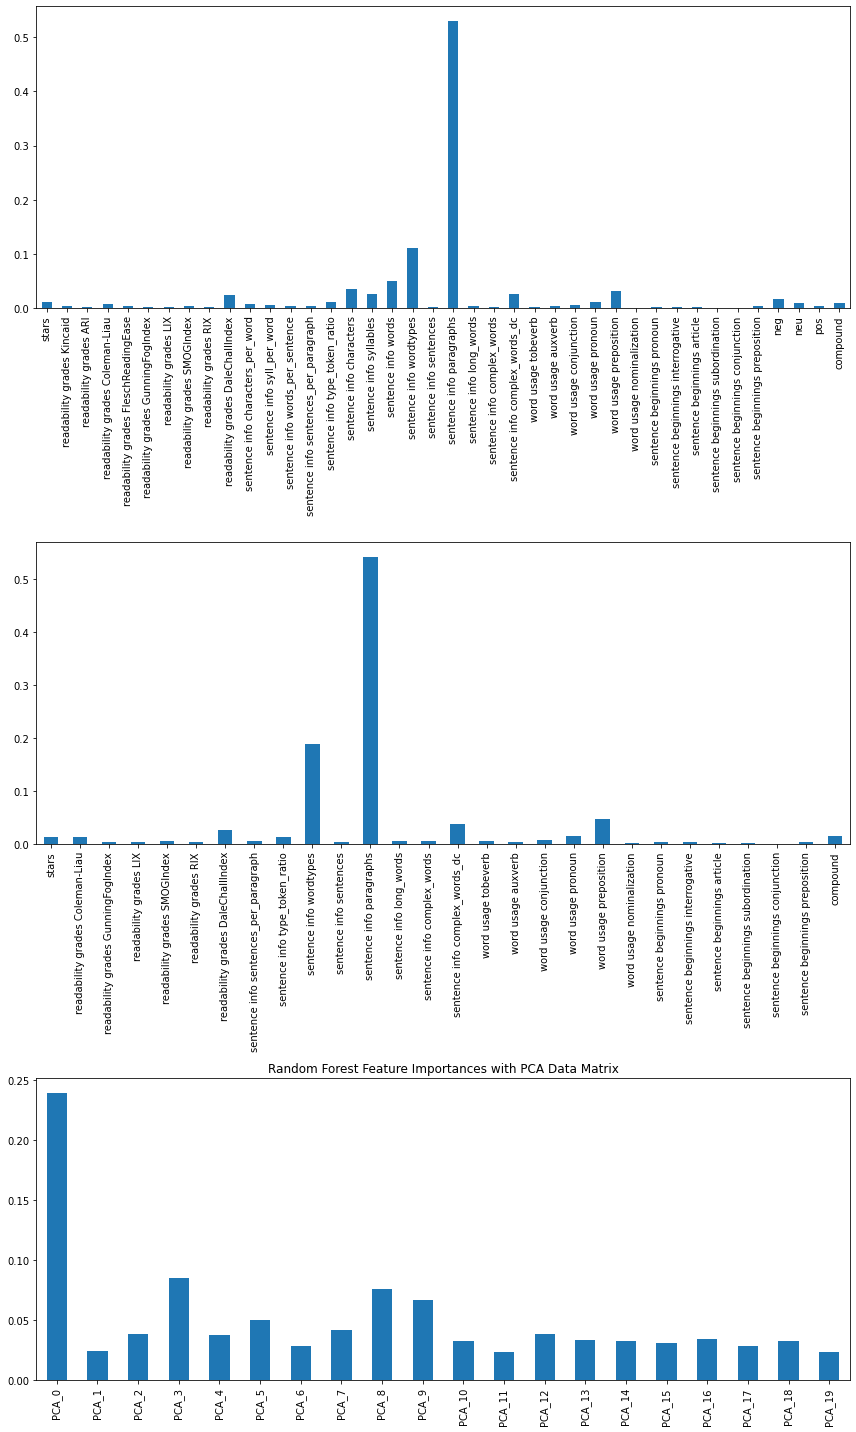

In [42]:
f, ax = plt.subplots(3,1,figsize = (12,20))

feature_significances = pd.Series(model_list[0].feature_importances_, index = X_train.columns)
feature_significances.plot(kind = "bar", ax = ax[0])
plt.title("Random Forest Feature Importances with Original Feature Matrix")

feature_significances1 = pd.Series(model_list[1].feature_importances_, index = X_vif.columns)
feature_significances1.plot(kind = "bar", ax = ax[1])
plt.title("Random Forest Feature Importances with VIF Data Matrix")

feature_significances1 = pd.Series(model_list[2].feature_importances_, index = X_pca.columns)
feature_significances1.plot(kind = "bar", ax = ax[2])
plt.title("Random Forest Feature Importances with PCA Data Matrix")

plt.tight_layout()

In [43]:
lr_base = LinearRegression()
lr_vif = LinearRegression()
lr_pca = LinearRegression()
lr_base.fit(X_train, y_train)
lr_vif.fit(X_vif, y_train)
lr_pca.fit(X_pca, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

First we'll look at the r2 score and rmse metrics from sklearn. From the sklearn, documentation

The coefficient R^2 is defined as (1 - u/v), where u is the residual sum of squares ((y_true - y_pred) ** 2).sum() and v is the total sum of squares ((y_true - y_true.mean()) ** 2).sum(). The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0

In [48]:
X_test_pca = pca.transform(X_test)
X_test_vif = X_test.copy()
for col in X_test.columns:
    if col not in X_vif.columns:
        X_test_vif.drop(columns = col, inplace = True)
#get r2 score and rmse for each model on test set
rf_base = model_list[0]
rf_vif = model_list[1]
rf_pca = model_list[2]
models = [(lr_base, rf_base, X_train, X_test), (lr_vif, rf_vif, X_vif, X_test_vif), 
          (lr_pca, rf_pca, X_pca, X_test_pca)]
r2_train_scores = []
r2_test_scores = []
rmse_train_scores = []
rmse_test_scores = []
for lr_model,rf_model, train, test in models:
        rmse_train_scores.append(rmse(actual = y_train, predicted = lr_model.predict(train)))
        rmse_train_scores.append(rmse(actual = y_train, predicted = rf_model.predict(train)))
        rmse_test_scores.append(rmse(actual = y_test, predicted = lr_model.predict(test)))
        rmse_test_scores.append(rmse(actual = y_test, predicted = rf_model.predict(test)))
        r2_train_scores.append(r2_score(y_train, lr_model.predict(train)))
        r2_train_scores.append(r2_score(y_train, rf_model.predict(train)))
        r2_train_scores.append(r2_score(y_test, lr_model.predict(test)))
        r2_test_scores.append(r2_score(y_test, rf_model.predict(test)))

In [ ]:
#four different barplots, 
f, ax = plt.subplots(2,2, figsize = (14,14))

#r2_train_score
